In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import euclidean
from sklearn.feature_selection import f_regression
from statsmodels.tsa.stattools import adfuller
from sklearn.manifold import TSNE
from DBCV import DBCV
import hdbscan
import csv
import multiprocessing
import itertools
import operator
import math
from dtaidistance import dtw
import seaborn as sns
import json
plt.style.use('fivethirtyeight')
from osgeo import gdal 
from subprocess import Popen
import simplekml
import copy
from sklearn.cluster import DBSCAN
import numpy.ma as ma
import rasterio
from pyproj import Proj
from affine import Affine
from pyproj import Proj, transform

In [3]:
velocities_path = 'rasters/mpic/'
mean_velocity_ns_filename = 'MM_Mean_velocity_NS_31TGK_20151227_to_20200906.tif'
mean_velocity_ew_filename = 'MM_Mean_velocity_EW_31TGK_20151227_to_20200906.tif'
analysis_quality_map_filename = 'MM_Analysis_quality_map_1126_lay_31TGK_20151227_to_20200906.tif'
vector_coherence_filename = 'MM_Vector_coherence_31TGK_20151227_to_20200906.tif'
mean_velocity_magnitude_filename = 'MM_Mean_veloc_magnitude_31TGK_20151227_to_20200906.tif'

In [4]:
inpath = 'rasters/mpic/'
input_filenames = [mean_velocity_ns_filename, mean_velocity_ew_filename, mean_velocity_magnitude_filename, vector_coherence_filename]
output_filenames  = ['velocity_NS', 'velocity_EW', 'veloc_magnitude', 'Vector_coherence']

In [7]:
ns_velocities_rasterio = rasterio.open(velocities_path + mean_velocity_ns_filename)
ns_velocities_raster = gdal.Open(velocities_path + mean_velocity_ns_filename)
ew_velocities_raster = gdal.Open(velocities_path + mean_velocity_ew_filename)
analysis_quality_raster = gdal.Open(velocities_path + analysis_quality_map_filename)
vector_coherence_raster = gdal.Open(velocities_path + vector_coherence_filename)
velocity_magnitude_raster = gdal.Open(velocities_path + mean_velocity_magnitude_filename)

In [8]:
ns_velocities = ns_velocities_raster.GetRasterBand(1).ReadAsArray()
ew_velocities = ew_velocities_raster.GetRasterBand(1).ReadAsArray()
analysis_quality = analysis_quality_raster.GetRasterBand(1).ReadAsArray()
vector_coherence = vector_coherence_raster.GetRasterBand(1).ReadAsArray()
velocity_magnitude_g = velocity_magnitude_raster.GetRasterBand(1).ReadAsArray()

In [9]:
class Raster():
    
    def __init__(self):
        pass
    
    def split_raster2(self, in_path, input_filename, output_filename, x_pixel_step, y_pixel_step):

        ds = gdal.Open(in_path + input_filename)
        xsize = ds.RasterXSize
        ysize = ds.RasterYSize
        
        n_count = 0
        for i in range(0, xsize, x_pixel_step):
            for j in range(0, ysize, y_pixel_step):
                print(i,j, n_count)
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(x_pixel_step) + ", " + str(y_pixel_step) + " " + str(in_path) + str(input_filename) + " " + str(in_path) + 'split_' + str(output_filename) + '_' + str(n_count) + ".tif"
                os.system(com_string)
                n_count += 1
    
    def split_raster(self, in_path, input_filename, output_filename, n_split=5):

        ds = gdal.Open(in_path + input_filename)
        band = ds.GetRasterBand(1)
        xsize = band.XSize
        ysize = band.YSize

        tile_size_x = math.ceil(xsize / n_split)
        tile_size_y = ysize # on découpe le raster verticalement !
        n_count = 0
        for i in range(0, xsize, tile_size_x):
            for j in range(0, ysize, tile_size_y):
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(in_path) + str(input_filename) + " " + str(in_path) + 'split_' + str(output_filename) + '_' + str(n_count) + ".tif"
                os.system(com_string)
                n_count += 1
        ds = None
        
    def split_rasters2(self, in_path, input_filenames, output_filenames,  x_pixel_step=3323, y_pixel_step=371):
        for input_filename, output_filename in zip(input_filenames, output_filenames):
            self.split_raster2(in_path, input_filename, output_filename, x_pixel_step=x_pixel_step, y_pixel_step=y_pixel_step)

    def split_rasters(self, in_path, input_filenames, output_filenames, n_split=5):
        for input_filename, output_filename in zip(input_filenames, output_filenames):
            self.split_raster(in_path, input_filename, output_filename, n_split=n_split)
        
    def load_split_rasters(self, in_path, output_filenames, n_splits=5):
        rasters, filenames_to_load = [], []
        for output_filename in output_filenames:
            filenames_to_load.append(['split_' + output_filename + '_' + str(n) + '.tif' for n in range(n_splits)])
        for n in range(n_splits):
            files = [rasterio.open(in_path + files[n]) for files in filenames_to_load]
            rasters.append(tuple(files))
        return rasters
    
    def getBoxBounds(self, raster):
        min_y = raster.bounds.bottom
        max_y = raster.bounds.top
        min_x = raster.bounds.left
        max_x = raster.bounds.right
        min_lat, min_lon = proj(min_x, min_y, inverse=True)
        max_lat, max_lon = proj(max_x, max_y, inverse=True)
        return (min_x, min_y, max_x, max_y), (min_lon, min_lat, max_lon, max_lat)
    
    def compute_slope_azimuth_map(self, dem_path, output_name):
        dem = gdal.Open(dem_path)
        slope_map = gdal.DEMProcessing('rasters/azimuths/' + output_name + '.tif', dem, 'aspect', computeEdges = True, trigonometric=False)
        dem = None
        slope_map = None
        
    def compute_slope_map(self, dem_path, output_name):
        dem = gdal.Open(dem_path)
        slope_map = gdal.DEMProcessing('rasters/slopes/' + output_name + '.tif', dem, 'slope', computeEdges = True)
        dem = None
        slope_map = None
        
    def compute_slope_azimuth_map_from_scratch():
        pass
    
    def extract_value_from_raster(self, lat, lon, file, ref='wgs84'):
        val = os.popen('gdallocationinfo -valonly -%s %s %f %f' % (ref, file, lat, lon)).read()
        if len(val) == 0:
            raise ValueError('La valeur est non valide !')
        return float(val)
    
    def generate_shapefile(self, raster_in_path, shapefile_out_path):
        cmd = ["gdaltindex", shapefile_out_path, raster_in_path]
        subprocess.run(cmd1)
        
    def get_raster_resolution(self, raster):
        xres, yres = rasterio.open(raster).res
        return xres, yres
    
    def cut_raster(raster_output, shapefile_output, xres, yres):
        small_raster = gdal.Warp(raster_output, ds, cutlineDSName=shapefile_output, cropToCutline=True, dstNodata=np.nan, xRes=pxsz, yRes=pysz, resampleAlg='cubic')
        small_raster = None
    
    def split_raster3(self, in_path, input_filename, output_filename, x_pixel_step, y_pixel_step):
        raster = gdal.Open(in_path + input_filename)
        gt = raster.GetGeoTransform()
        
        xmin = gt[0]
        ymax = gt[3]
        res = gt[1]
        xlen = res * raster.RasterXSize
        ylen = res * raster.RasterYSize

        xsize = x_pixel_step * res
        ysize = y_pixel_step * res

        xnsplits = int(raster.RasterXSize / x_pixel_step)
        ynsplits = int(raster.RasterYSize / y_pixel_step)

        xsteps = [xmin + xsize * i for i in range(xnsplits + 1)]
        ysteps = [ymax - ysize * i for i in range(ynsplits + 1)]
    
        n_count = 0
        for i in range(xnsplits):
            for j in range(ynsplits):
                xmin_ = xsteps[i]
                xmax_ = xsteps[i + 1]
                ymax_ = ysteps[j]
                ymin_ = ysteps[j + 1]
                print(xmin_, xmax_, ymin_, ymax_)
                #gdal.Warp(raster_filename + str(i) + str(j) + '.tif', raster, outputBounds=(xmin_, xmax_, ymin_, ymax_), dstNodata=-9999)
                gdal.Translate(inpath + 'split_' + output_filename + '_' + str(n_count) + '.tif', raster, projWin=(xmin_, ymax_, xmax_, ymin_))
                n_count += 1
        raster = None
        
                
    def split_rasters3(self, in_path, input_filenames, output_filenames,  x_pixel_step=3323, y_pixel_step=371):
        for input_filename, output_filename in zip(input_filenames, output_filenames):
            self.split_raster3(in_path, input_filename, output_filename, x_pixel_step, y_pixel_step)
            
            
    def from_utm_to_lat_lon(self, filename):
        # Read raster
        with rasterio.open(filename) as r:
            T0 = r.transform  # upper-left pixel corner affine transform
            p1 = Proj(r.crs)
            A = r.read()  # pixel values

        # All rows and columns
        cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

        # Get affine transform for pixel centres
        T1 = T0 * Affine.translation(0.5, 0.5)
        # Function to convert pixel row/column index (from 0) to easting/northing at centre
        rc2en = lambda r, c: (c, r) * T1

        # All eastings and northings (there is probably a faster way to do this)
        eastings, northings = np.vectorize(rc2en, otypes=[float, float])(rows, cols)

        # Project all longitudes, latitudes
        p2 = Proj(proj='latlong',datum='WGS84')
        lats, lons = transform(p1, p2, eastings, northings)

        return lats, lons
    
    def compute_azimuths(self, raster_azimuth_name, raster_ns_vel_name, raster_ew_vel_name):
        gdal_azimuths = rasterio.open(raster_azimuth_name).read(1)
        ns_velocities = rasterio.open(raster_ns_vel_name).read(1)
        ew_velocities = rasterio.open(raster_ew_vel_name).read(1)
        azimuths = np.arctan2(ew_velocities, ns_velocities)
        azimuths = np.where(azimuths >= 0, azimuths, azimuths + 2 * np.pi)
        azimuths = np.degrees(azimuths)
        #azimuths_mask = np.logical_and(azimuths > gdal_azimuths - tol, azimuths < gdal_azimuths + tol)
        return gdal_azimuths, azimuths

In [10]:
def convert_to_lat_lon(x, y, epsg_code='32631'):
    proj = Proj("epsg:" + epsg_code, preserve_units=False)
    return p(x, y, inverse=True)

def compute_lat_lon_matrix(raster):
    latitudes, longitudes = [], []
    for i in range(raster.height):
        for j in range(raster.width):
            utms = raster.transform * (i, j)
            lat, lon = convert_to_lat_lon(utms[0], utms[1])
            latitudes.append(lat)
            longitudes.append(lon)
    return np.array(latitudes).reshape(raster.height, raster.width), np.array(longitudes).reshape(raster.height, raster.width)

def generate_kml_file(latitudes, longitudes, color, zone, filename):
    
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    kml = simplekml.Kml()
    for latitude, longitude in zip(latitudes, longitudes):
        pnt = kml.newpoint(description='', coords=[(latitude, longitude)])
        pnt.iconstyle.icon.href = url + color + '-dot.png'
    kml.save('Resultats/zone' + str(zone) + '/' + filename + '.kml')
    
    
def generate_kml_file2(latitudes, longitudes, color, filename):
    
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    kml = simplekml.Kml()
    for latitude, longitude in zip(latitudes, longitudes):
        pnt = kml.newpoint(description='', coords=[(latitude, longitude)])
        pnt.iconstyle.icon.href = url + color + '-dot.png'
    kml.save('Resultats/' + filename + '.kml')

    
def generate_kml_file_ll(latitudes, longitudes, labels):
    if labels.max() > -1:
        icones = generate_icones2()
        dense_cluster_labels = get_important_labels(labels)
        kml=simplekml.Kml()
        fol = kml.newfolder(name="HDBSCAN Clustering")
        for n in range(latitudes.shape[0]):
            pnt = None
            if labels[n] > -1:
                pnt = fol.newpoint(description='', coords=[(latitudes[n], longitudes[n])])
                if labels[n] in dense_cluster_labels:
                    ind = dense_cluster_labels.index(labels[n])
                    pnt.iconstyle.icon.href = icones[ind]
                else:
                    pnt.iconstyle.icon.href = icones[-1]
        kml.save('Resultats/clustering_results.kml')
        print('ok finished')
    else:
        print('Hdbscan only found outliers. kml file cannot be generated !')
            
def generate_icones2():
    base = 'http://maps.google.com/mapfiles/ms/micons/'
    colors = ['blue', 'red', 'yellow', 'green', 'orange', 'purple', 'pink']
    return [base + color + '-dot.png' for color in (colors + ['ltblue'])[:]] + [base + color + '.png' for color in (colors + ['lightblue'])[:]]

def get_important_labels(labels, n_classes=15):
    classes = []
    unique, counts = np.unique(labels, return_counts=True)
    sort_labels = sorted(dict(zip(unique, counts)).items(), key=lambda x: x[1], reverse=True)
    for label, count in sort_labels:
        if label > -1 and len(classes) < n_classes:
            classes.append(label)
    return classes

# Clustering des vitesses

In [14]:
# zone 1 (zone de lavalette)
magnitude_veloc_zone1 = rasterio.open('rasters/mpic/zones/zone1/veloc_magnitude.tif')
coherence_zone1 =  rasterio.open('rasters/mpic/zones/zone1/Vector_coherence.tif')
ew_veloc_zone1 =  rasterio.open('rasters/mpic/zones/zone1/velocity_EW.tif')
ns_veloc_zone1 =  rasterio.open('rasters/mpic/zones/zone1/velocity_NS.tif')
slopes_zone1 = rasterio.open('rasters/slopes/validation_zone1.tif')
mnt_azimuth_zone1, azimuths_zone1 = Raster().compute_azimuths('rasters/azimuths/validation_zone1.tif', 'rasters/mpic/zones/zone1/velocity_NS.tif', 'rasters/mpic/zones/zone1/velocity_EW.tif')


# zone 2 (zone au nord de la lavalette, pente abrupte et absence de végétation)
magnitude_veloc_zone2 = rasterio.open('rasters/mpic/zones/zone2/veloc_magnitude.tif')
coherence_zone2 =  rasterio.open('rasters/mpic/zones/zone2/Vector_coherence.tif')
ew_veloc_zone2 =  rasterio.open('rasters/mpic/zones/zone2/velocity_EW.tif')
ns_veloc_zone2 =  rasterio.open('rasters/mpic/zones/zone2/velocity_NS.tif')

# zone 3 (contenant le polygone 6)
magnitude_veloc_zone3 = rasterio.open('rasters/mpic/zones/zone3/veloc_magnitude.tif')
coherence_zone3 =  rasterio.open('rasters/mpic/zones/zone3/Vector_coherence.tif')
ew_veloc_zone3 =  rasterio.open('rasters/mpic/zones/zone3/velocity_EW.tif')
ns_veloc_zone3 =  rasterio.open('rasters/mpic/zones/zone3/velocity_NS.tif')

# zone 4 (la cohérence est nulle sur cette zone)
magnitude_veloc_zone4 = rasterio.open('rasters/mpic/zones/zone4/veloc_magnitude.tif')
coherence_zone4 =  rasterio.open('rasters/mpic/zones/zone4/Vector_coherence.tif')
ew_veloc_zone4 =  rasterio.open('rasters/mpic/zones/zone4/velocity_EW.tif')
ns_veloc_zone4 =  rasterio.open('rasters/mpic/zones/zone4/velocity_NS.tif')

# Statistiques

<ipython-input-15-a8d06d577bbd>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Pourcentage de valeurs de cohérence nulle par zone', fontSize=15)


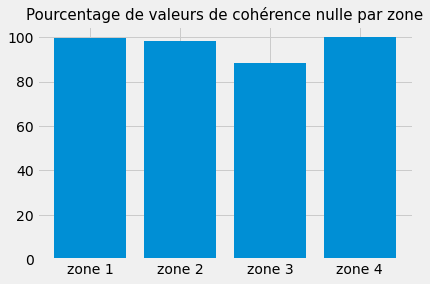

In [15]:
zeros_zones = {'zone ' + str(i+1): 0 for i in range(4)}
for zone, raster in zip(zeros_zones.keys(), [coherence_zone1, coherence_zone2, coherence_zone3, coherence_zone4]):
    n_samples = raster.read(1).flatten().shape[0]
    n_zeros = np.count_nonzero(raster.read(1).flatten() == 0.0)
    zeros_zones[zone] = 100 * n_zeros / n_samples

plt.bar(*zip(*zeros_zones.items()))
plt.title('Pourcentage de valeurs de cohérence nulle par zone', fontSize=15)
plt.show()

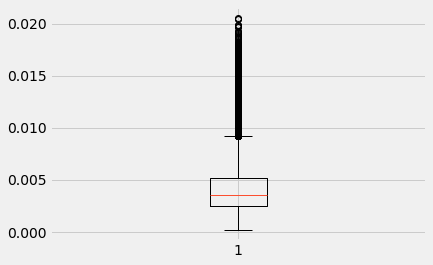

In [251]:
plt.boxplot(magnitude_veloc_zone1.read(1).flatten())
plt.show()

In [21]:
min_cluster_size = 50
min_samples = 100

fname = 'rasters/mpic/zones/zone1/veloc_magnitude.tif'
lats, lons = Raster().from_utm_to_lat_lon(fname)
lats = lats.flatten()
lons = lons.flatten()
std_vel = np.nanstd(magnitude_veloc_zone1.read(1))
#mask = raster.read(1) > max_coherence / 100000000000
#mask = raster.read(1) > 1.5 * std_vel
tol = 80
azmth = azimuths_zone1.flatten()
mnt_azmth = mnt_azimuth_zone1.flatten()
mask = (magnitude_veloc_zone1.read(1).flatten() > 1.5 * std_vel) & np.logical_and(azmth < mnt_azmth + tol,  azmth > mnt_azmth - tol)
mask = mask.flatten()

lats_r = np.radians(lats[mask])
lons_r = np.radians(lons[mask])
X = np.stack((lats_r, lons_r), axis=-1)

#generate_kml_file2(lats[mask], lons[mask], 'yellow', 'filtering')
clustering_results = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=None,  gen_min_span_tree=True, metric='haversine').fit(X)

<ipython-input-9-805a1b29a76f>:147: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-9-805a1b29a76f>:154: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


In [22]:
generate_kml_file_ll(lats[mask], lons[mask], clustering_results.labels_)

ok finished


# Clustering et Detection

In [261]:
class Clustering():
    def __init__(self, raster_vel_name, raster_ns_vel_name, raster_ew_vel_name, raster_coherence_name, raster_slope_name, raster_azimuth_name):
        mnt_azimuths, azimuths = Raster().compute_azimuths(raster_azimuth_name, raster_ns_vel_name, raster_ew_vel_name)
        latitudes, longitudes = Raster().from_utm_to_lat_lon(raster_vel_name)
        self.velocities = rasterio.open(raster_vel_name).read(1).flatten()
        self.ns_velocities = rasterio.open(raster_ns_vel_name).read(1).flatten()
        self.ew_velocities = rasterio.open(raster_ew_vel_name).read(1).flatten()
        self.coherences = rasterio.open(raster_coherence_name).read(1).flatten()
        self.slopes = rasterio.open(raster_slope_name).read(1).flatten()
        self.mnt_azimuths = mnt_azimuths.flatten()
        self.azimuths = azimuths.flatten()
        self.latitudes = latitudes.flatten()
        self.longitudes = longitudes.flatten()
        self.std_vel = np.nanstd(self.velocities)
        self.clustering_results = None
        self.cluster_member_indexes = None
        self.velocities_mask = None
        self.slopes_mask = None

    def set_slopes_mask(self, slopes_mask):
        self.slopes_mask = slopes_mask
        
    def set_velocities_mask(self, velocities_mask):
        self.velocities_mask = velocities_mask
        
    def set_clustering_results(self, clustering_results):
        self.clustering_results = clustering_results
        
    def set_cluster_member_indexes(self, cluster_member_indexes):
        self.cluster_member_indexes = cluster_member_indexes
        
    def filter(self):
        pass
    
    def cluster(self, factor=2, min_cluster_size=50, min_samples=None, metric='haversine'):
        mask = np.absolute(self.velocities) > factor * self.std_vel
        mask = mask.flatten()
        
        lats_r = np.radians(self.latitudes[mask])
        lons_r = np.radians(self.longitudes[mask])

        X = np.stack((lats_r, lons_r), axis=-1)
        clustering_results = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,  gen_min_span_tree=True, metric=metric).fit(X)
        
        self.set_clustering_results(clustering_results)
        #self.set_cluster_member_indexes()
        
        return self.latitudes[mask], self.longitudes[mask], clustering_results
    
    def filter_slopes(self, min_slope=15):
        labels = self.clustering_results.label_
        mask = self.slopes > min_slope
        n_clusters = labels.max() + 1 if labels.max() > -1 else 0
        
    
    def compute_statistiques(self, clustering_results, tol=60):
        labels = clustering_results.labels_
        n_clusters = labels.max() + 1 if labels.max() > -1 else 0
        cluster_members_index = [np.where(labels == label) for label in np.unique(labels)]
        if labels.min() < 0:
            cluster_members_index = cluster_members_index[1:]
        
        mean_cluster_velocities = []
        mean_cluster_coherences = []
        std_cluster_delta_azimuths = []
        percentage_valid = []
        mean_cluster_slopes = []

        # statistiques 
        for n in range(n_clusters):
            cluster = cluster_members_index[n][0]
            print(cluster.shape[0])
            mean_cluster_velocities.append(self.velocities[cluster].mean())
            mean_cluster_coherences.append(self.coherences[cluster].mean())
            mean_cluster_slopes.append(self.slopes[cluster].mean())
            mnt_azimuths = self.mnt_azimuths[cluster]
            azimuths = self.azimuths[cluster]
            azimuths_mask = np.logical_and(azimuths > mnt_azimuths - tol, azimuths < mnt_azimuths + tol)
            percentage = 100 * np.count_nonzero(azimuths_mask) /  azimuths_mask.shape[0]
            percentage_valid.append(percentage)
            #std_cluster_delta_azimuths.append((mnt_azimuths - azimuths).std())
        return mean_cluster_velocities, mean_cluster_coherences, mean_cluster_slopes, percentage_valid

In [253]:
raster_vel_name = 'rasters/mpic/zones/zone1/veloc_magnitude.tif'
raster_ew_vel_name = 'rasters/mpic/zones/zone1/velocity_EW.tif'
raster_ns_vel_name = 'rasters/mpic/zones/zone1/velocity_NS.tif'
raster_coherence_name = 'rasters/mpic/zones/zone1/Vector_coherence.tif'
raster_slope_name = 'rasters/slopes/validation_zone1.tif'
raster_azimuth_name = 'rasters/azimuths/validation_zone1.tif'

In [262]:
clustering = Clustering(raster_vel_name, raster_ns_vel_name, raster_ew_vel_name, raster_coherence_name, raster_slope_name, raster_azimuth_name)

<ipython-input-63-805a1b29a76f>:147: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
<ipython-input-63-805a1b29a76f>:154: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lats, lons = transform(p1, p2, eastings, northings)


In [263]:
latitudes, longitudes, clustering_results = clustering.cluster(min_cluster_size=50)

In [264]:
generate_kml_file_ll(latitudes, longitudes, clustering_results.labels_)

KeyboardInterrupt: 

In [ ]:
mean_cluster_velocities, mean_cluster_coherences, mean_cluster_slopes, percentages = clustering.compute_statistiques(clustering_results)

# Clustering avec une mésure de similarité

In [149]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

ew_velocities_zone1 = rasterio.open('rasters/mpic/zones/zone1/velocity_EW.tif').read(1)
ns_velocities_zone1 = rasterio.open('rasters/mpic/zones/zone1/velocity_NS.tif').read(1)
velocities_zone1 = rasterio.open('rasters/mpic/zones/zone1/veloc_magnitude.tif').read(1)

std_vel = np.nanstd(velocities_zone1)
mask_vel = velocities_zone1.flatten() >  3 * std_vel 
mask_nan = np.isnan(velocities_zone1.flatten())

In [150]:
ew_vel = ew_velocities_zone1.flatten()[mask_vel]
ew_vel.shape

(11867,)

In [151]:
ew_vel = ew_velocities_zone1.flatten()[mask_vel]
ns_evl = ns_velocities_zone1.flatten()[mask_vel]
vectors = np.stack((ew_vel, ns_evl), axis=-1)
#similarity_matrix = cosine_similarity(vectors)
clustering_results = DBSCAN(eps=3, min_samples=30, metric='cosine').fit(vectors)